### ライブラリインポート

In [25]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# PyTorch関連ライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# 機械学習関連ライブラリ
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import os

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

# シード設定
torch.manual_seed(42)
np.random.seed(42)

使用デバイス: cpu


### csv読込み

In [10]:
df = pd.read_csv("../data/raw/UrbanSound8K/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### スペクトログラム変換

In [12]:
dat1, sampling_rate1 = librosa.load('../data/raw/UrbanSound8K/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('../data/raw/UrbanSound8K/fold5/100263-2-0-117.wav')

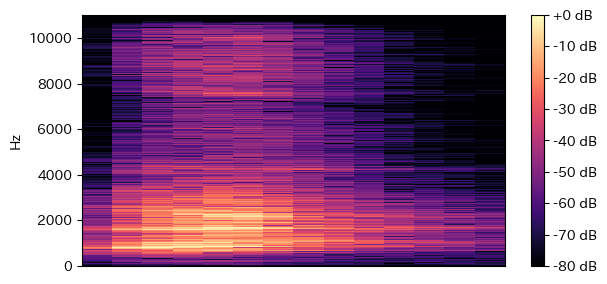

In [19]:
plt.figure(figsize=(15, 15))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis="linear")
plt.colorbar(format='%+2.0f dB')

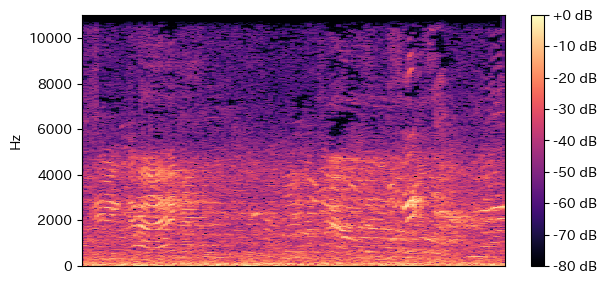

In [22]:
plt.figure(figsize=(15, 15))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')

データセットの形状: (8732, 8)

クラス分布:
class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64


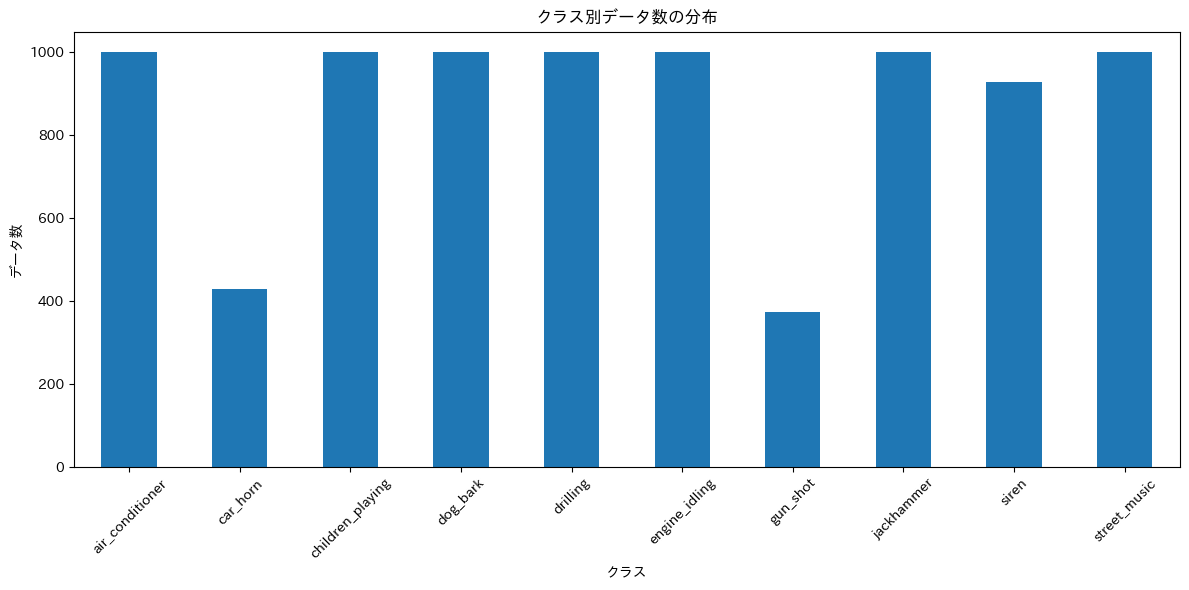

In [26]:
# データの基本情報確認
print("データセットの形状:", df.shape)
print("\nクラス分布:")
print(df['class'].value_counts().sort_index())

# クラス分布の可視化
plt.figure(figsize=(12, 6))
df['class'].value_counts().sort_index().plot(kind='bar')
plt.title('クラス別データ数の分布')
plt.xlabel('クラス')
plt.ylabel('データ数')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### librosaを使ったスペクトログラム変換関数

In [27]:
def extract_spectrogram(file_path, target_shape=(128, 128), duration=4.0):
    """
    librosaを使って音声ファイルからスペクトログラムを抽出
    
    Args:
        file_path: 音声ファイルのパス
        target_shape: 出力するスペクトログラムの形状 (height, width)
        duration: 音声の長さ（秒）
    
    Returns:
        スペクトログラム（dB変換済み）のnumpy配列
    """
    try:
        # 音声ファイル読み込み
        y, sr = librosa.load(file_path, sr=22050, duration=duration)
        
        # パディングまたは切り詰め（指定秒数に正規化）
        target_length = int(sr * duration)
        if len(y) > target_length:
            y = y[:target_length]
        else:
            y = np.pad(y, (0, target_length - len(y)), 'constant')
        
        # STFT計算
        stft = librosa.stft(y, n_fft=1024, hop_length=512)
        magnitude = np.abs(stft)
        
        # dB変換
        db_spec = librosa.amplitude_to_db(magnitude, ref=np.max)
        
        # 指定サイズにリサイズ
        if db_spec.shape != target_shape:
            # 補間でリサイズ
            from scipy.ndimage import zoom
            zoom_factors = (target_shape[0] / db_spec.shape[0], 
                          target_shape[1] / db_spec.shape[1])
            db_spec = zoom(db_spec, zoom_factors)
        
        # 正規化 (-1 to 1)
        db_spec = (db_spec - db_spec.min()) / (db_spec.max() - db_spec.min())
        db_spec = 2 * db_spec - 1
        
        return db_spec.astype(np.float32)
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(target_shape, dtype=np.float32)

### PyTorch Dataset クラス

In [28]:
class UrbanSound8KDataset(Dataset):
    """
    UrbanSound8K用のPyTorchデータセットクラス
    """
    def __init__(self, df, data_path, target_shape=(128, 128), duration=4.0):
        self.df = df.reset_index(drop=True)
        self.data_path = data_path
        self.target_shape = target_shape
        self.duration = duration
        
        # ラベルエンコーダー
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(df['class'])
        self.num_classes = len(self.label_encoder.classes_)
        
        print(f"クラス数: {self.num_classes}")
        print(f"クラス: {self.label_encoder.classes_}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = os.path.join(self.data_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # スペクトログラム抽出
        spectrogram = extract_spectrogram(file_path, self.target_shape, self.duration)
        
        # チャンネル次元を追加 (1, H, W)
        spectrogram = np.expand_dims(spectrogram, axis=0)
        
        # PyTorchテンソルに変換
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return spectrogram, label

### PyTorchモデル定義（CNN・FCNN）

In [29]:
class SpectrogramCNN(nn.Module):
    """
    スペクトログラム分類用CNN
    """
    def __init__(self, num_classes=10, input_channels=1):
        super(SpectrogramCNN, self).__init__()
        
        # 畳み込み層1
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # 畳み込み層2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # 畳み込み層3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        # 畳み込み層4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(0.25)
        
        # 全結合層の入力サイズを計算 (128x128の場合: 8x8x256)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # 畳み込みブロック1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        # 畳み込みブロック2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        # 畳み込みブロック3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        # 畳み込みブロック4
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        # 平坦化
        x = x.view(x.size(0), -1)
        
        # 全結合層
        x = self.dropout_fc1(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout_fc2(F.relu(self.bn_fc2(self.fc2(x))))
        x = self.fc3(x)
        
        return x

In [30]:
class SpectrogramFCNN(nn.Module):
    """
    スペクトログラム分類用FCNN（全結合ニューラルネットワーク）
    """
    def __init__(self, num_classes=10, input_size=128*128):
        super(SpectrogramFCNN, self).__init__()
        
        # 全結合層
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.3)
        
        self.fc5 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # 入力を平坦化
        x = x.view(x.size(0), -1)
        
        # 全結合層
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        
        return x

### データ準備とモデル訓練

In [31]:
# 設定
SAMPLE_SIZE = 500  # 最初は小さなサンプルでテスト（高速化のため）
TARGET_SHAPE = (128, 128)  # スペクトログラムの形状
DATA_PATH = "../data/raw/UrbanSound8K"
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 10

print("サンプルデータでテスト実行します...")
print(f"サンプルサイズ: {SAMPLE_SIZE}")

# サンプルデータでデータセット作成
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42)
dataset = UrbanSound8KDataset(df_sample, DATA_PATH, TARGET_SHAPE)

# 訓練・検証データに分割
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"訓練データ数: {len(train_dataset)}")
print(f"検証データ数: {len(val_dataset)}")
print(f"クラス数: {dataset.num_classes}")

サンプルデータでテスト実行します...
サンプルサイズ: 500
クラス数: 10
クラス: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
訓練データ数: 400
検証データ数: 100
クラス数: 10


In [32]:
def train_model(model, train_loader, val_loader, epochs, learning_rate, model_name):
    """
    モデルを訓練する関数
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
        
        # 検証フェーズ
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()
        
        # 統計計算
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
    
    # 結果の可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 損失の推移
    ax1.plot(range(1, epochs+1), train_losses, label='Train Loss')
    ax1.plot(range(1, epochs+1), val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Loss推移')
    ax1.legend()
    ax1.grid(True)
    
    # 精度の推移
    ax2.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    ax2.plot(range(1, epochs+1), val_accuracies, label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{model_name} - Accuracy推移')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

CNNモデルの訓練を開始します
CNNモデルのパラメータ数: 8,913,354


Epoch 1/10 [Train]: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]


Epoch 1/10:
  Train Loss: 2.2633, Train Acc: 16.75%
  Val Loss: 2.1112, Val Acc: 23.00%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


Epoch 2/10:
  Train Loss: 2.0355, Train Acc: 26.75%
  Val Loss: 1.8338, Val Acc: 32.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


Epoch 3/10:
  Train Loss: 1.9522, Train Acc: 29.00%
  Val Loss: 1.7594, Val Acc: 41.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 25/25 [00:07<00:00,  3.27it/s]


Epoch 4/10:
  Train Loss: 1.9093, Train Acc: 29.50%
  Val Loss: 1.7104, Val Acc: 36.00%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Epoch 5/10:
  Train Loss: 1.8316, Train Acc: 30.75%
  Val Loss: 1.6309, Val Acc: 39.00%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 6/10:
  Train Loss: 1.7958, Train Acc: 32.25%
  Val Loss: 1.6161, Val Acc: 40.00%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


Epoch 7/10:
  Train Loss: 1.7112, Train Acc: 34.00%
  Val Loss: 1.5719, Val Acc: 41.00%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]


Epoch 8/10:
  Train Loss: 1.7417, Train Acc: 34.50%
  Val Loss: 1.5143, Val Acc: 50.00%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


Epoch 9/10:
  Train Loss: 1.6478, Train Acc: 37.50%
  Val Loss: 1.5256, Val Acc: 45.00%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


Epoch 10/10:
  Train Loss: 1.5653, Train Acc: 39.50%
  Val Loss: 1.4897, Val Acc: 46.00%
--------------------------------------------------


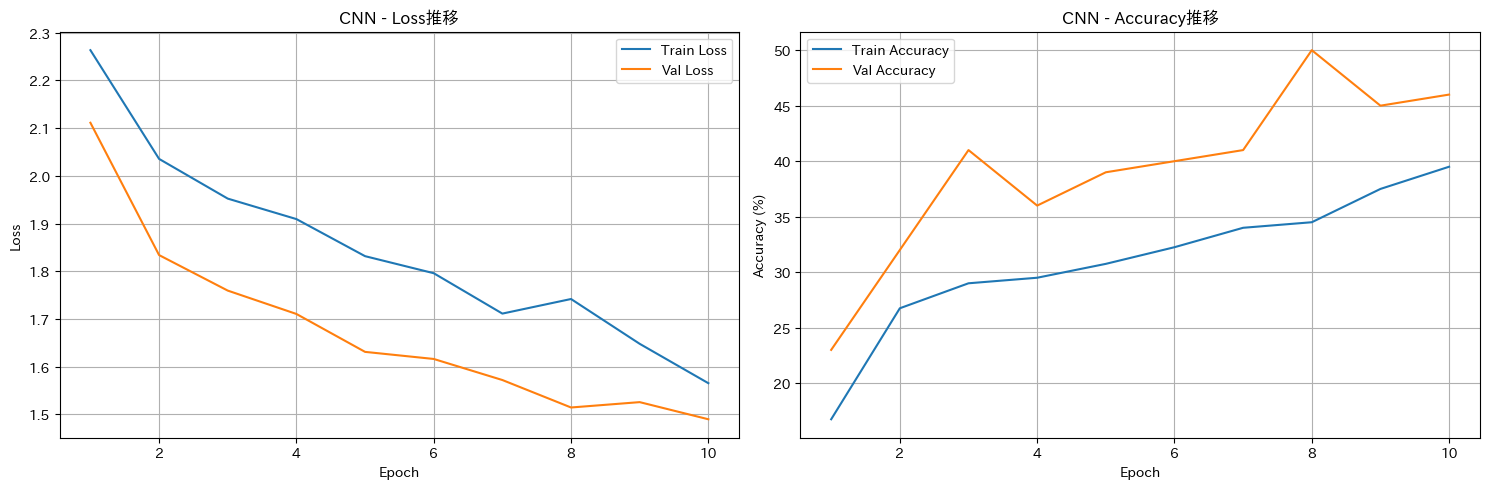

In [33]:
# CNNモデルの訓練
print("=" * 60)
print("CNNモデルの訓練を開始します")
print("=" * 60)

cnn_model = SpectrogramCNN(num_classes=dataset.num_classes)
print(f"CNNモデルのパラメータ数: {sum(p.numel() for p in cnn_model.parameters()):,}")

cnn_trained, cnn_train_losses, cnn_val_losses, cnn_train_acc, cnn_val_acc = train_model(
    cnn_model, train_loader, val_loader, EPOCHS, LEARNING_RATE, "CNN"
)

FCNNモデルの訓練を開始します
FCNNモデルのパラメータ数: 17,472,394


Epoch 1/10 [Train]: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s]


Epoch 1/10:
  Train Loss: 2.2606, Train Acc: 16.25%
  Val Loss: 2.0005, Val Acc: 26.00%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 2/10:
  Train Loss: 2.0427, Train Acc: 24.50%
  Val Loss: 1.9060, Val Acc: 26.00%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 3/10:
  Train Loss: 1.9502, Train Acc: 29.25%
  Val Loss: 1.8596, Val Acc: 34.00%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 4/10:
  Train Loss: 1.9229, Train Acc: 30.00%
  Val Loss: 1.8361, Val Acc: 33.00%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 5/10:
  Train Loss: 1.9311, Train Acc: 28.50%
  Val Loss: 1.8327, Val Acc: 29.00%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 6/10:
  Train Loss: 1.8960, Train Acc: 26.50%
  Val Loss: 1.8209, Val Acc: 32.00%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 7/10:
  Train Loss: 1.8486, Train Acc: 32.00%
  Val Loss: 1.8447, Val Acc: 29.00%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


Epoch 8/10:
  Train Loss: 1.9066, Train Acc: 27.50%
  Val Loss: 1.7707, Val Acc: 36.00%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 9/10:
  Train Loss: 1.9071, Train Acc: 30.50%
  Val Loss: 1.7709, Val Acc: 38.00%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 25/25 [00:04<00:00,  5.01it/s]


Epoch 10/10:
  Train Loss: 1.7913, Train Acc: 34.75%
  Val Loss: 1.7901, Val Acc: 35.00%
--------------------------------------------------


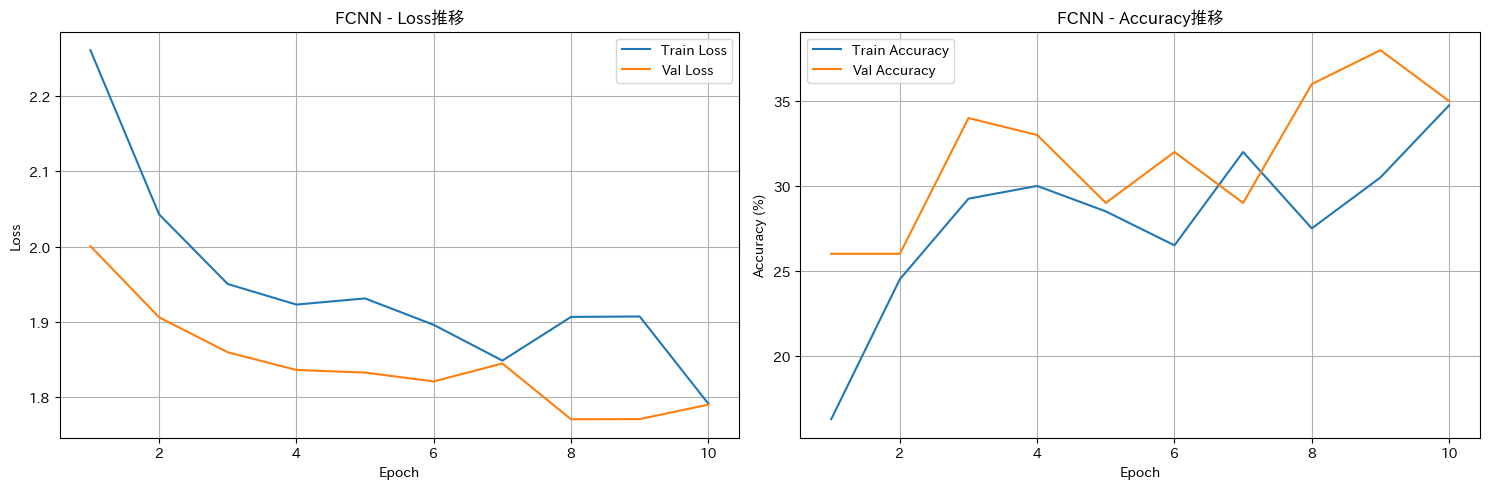

In [34]:
# FCNNモデルの訓練
print("=" * 60)
print("FCNNモデルの訓練を開始します")
print("=" * 60)

fcnn_model = SpectrogramFCNN(num_classes=dataset.num_classes, input_size=TARGET_SHAPE[0]*TARGET_SHAPE[1])
print(f"FCNNモデルのパラメータ数: {sum(p.numel() for p in fcnn_model.parameters()):,}")

fcnn_trained, fcnn_train_losses, fcnn_val_losses, fcnn_train_acc, fcnn_val_acc = train_model(
    fcnn_model, train_loader, val_loader, EPOCHS, LEARNING_RATE, "FCNN"
)

### モデル比較と結果分析

最終結果比較
CNN - 最終検証精度: 46.00%
FCNN - 最終検証精度: 35.00%


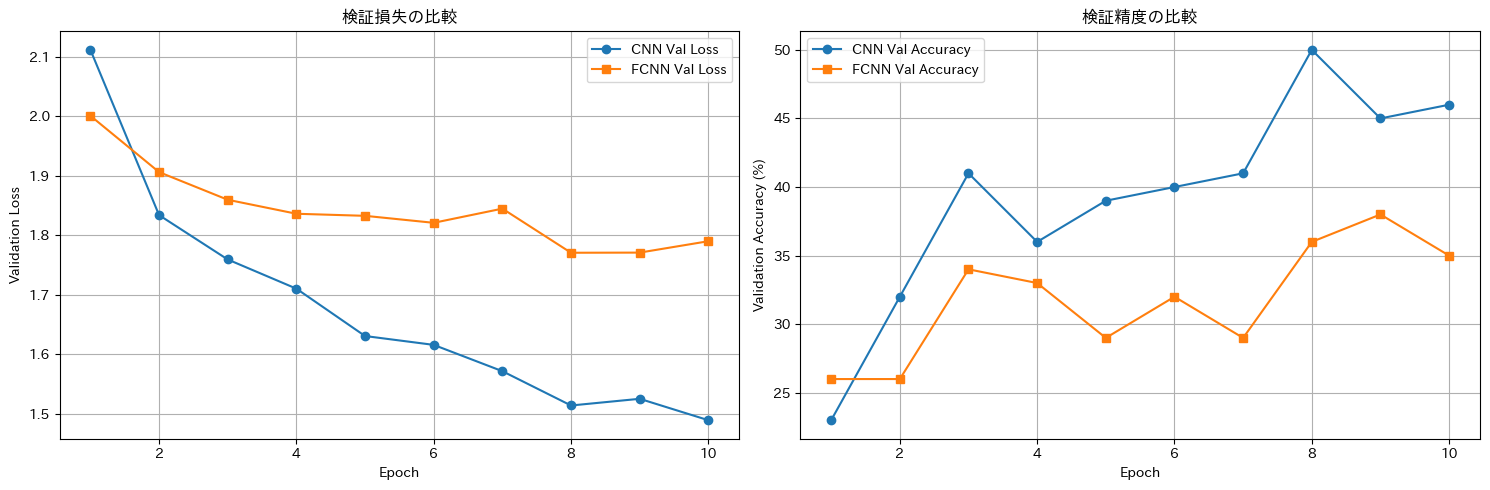


モデル詳細比較:
CNN  - パラメータ数: 8,913,354, 最終検証精度: 46.00%
FCNN - パラメータ数: 17,472,394, 最終検証精度: 35.00%

結果: CNNモデルの方が高い精度を達成しました


In [35]:
# 最終結果の比較
print("=" * 60)
print("最終結果比較")
print("=" * 60)

print(f"CNN - 最終検証精度: {cnn_val_acc[-1]:.2f}%")
print(f"FCNN - 最終検証精度: {fcnn_val_acc[-1]:.2f}%")

# 両モデルの学習曲線を比較
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 損失の比較
ax1.plot(range(1, EPOCHS+1), cnn_val_losses, label='CNN Val Loss', marker='o')
ax1.plot(range(1, EPOCHS+1), fcnn_val_losses, label='FCNN Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.set_title('検証損失の比較')
ax1.legend()
ax1.grid(True)

# 精度の比較
ax2.plot(range(1, EPOCHS+1), cnn_val_acc, label='CNN Val Accuracy', marker='o')
ax2.plot(range(1, EPOCHS+1), fcnn_val_acc, label='FCNN Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('検証精度の比較')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# モデルの詳細比較
cnn_params = sum(p.numel() for p in cnn_trained.parameters())
fcnn_params = sum(p.numel() for p in fcnn_trained.parameters())

print("\nモデル詳細比較:")
print(f"CNN  - パラメータ数: {cnn_params:,}, 最終検証精度: {cnn_val_acc[-1]:.2f}%")
print(f"FCNN - パラメータ数: {fcnn_params:,}, 最終検証精度: {fcnn_val_acc[-1]:.2f}%")

if cnn_val_acc[-1] > fcnn_val_acc[-1]:
    print("\n結果: CNNモデルの方が高い精度を達成しました")
else:
    print("\n結果: FCNNモデルの方が高い精度を達成しました")